# Summary:
This notebook will cover deep learning models. Self-trained word vectors are used as embedding matrix and recurrent neural network (RNN) are trained to classify text.

# Table of contents
<br >&nbsp;&nbsp;&nbsp;[3.9 Word2Vec](#Part3.9_link)
<br >&nbsp;&nbsp;&nbsp;[3.10 RNN model_1: simple RNN](#Part3.10_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.10.1 Build PM_RNN1 model](#Part3.10.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.10.2 Train PM_RNN1 model](#Part3.10.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.10.3 Visualize training performance](#Part3.10.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.10.4 Model evaluation](#Part3.10.4_link)
<br >&nbsp;&nbsp;&nbsp;[3.11 RNN model_2](#Part3.11_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.11.1 Build PM_RNN2 model](#Part3.11.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.11.2 Train PM_RNN2 model](#Part3.11.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.11.3 Visualize training performance](#Part3.11.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.11.4 Model evaluation](#Part3.11.4_link)
<br >&nbsp;&nbsp;&nbsp;[3.12 RNN model_3: BiLSTM + Conv1D](#Part3.12_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.12.1 Build PM_RNN3 model](#Part3.12.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.12.2 Train PM_RNN3 model](#Part3.12.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.12.3 Visualize training performance](#Part3.12.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.12.4 Model evaluation](#Part3.12.4_link)
<br >&nbsp;&nbsp;&nbsp;[3.13 RNN model_4: Conv1D + BiLSTM](#Part3.13_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.13.1 Build PM_RNN4 model](#Part3.13.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.13.2 Train PM_RNN4 model](#Part3.13.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.13.3 Visualize training performance](#Part3.13.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.13.4 Model evaluation](#Part3.13.4_link)
<br >&nbsp;&nbsp;&nbsp;[3.14 RNN model_5](#Part3.14_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.14.1 Build PM_RNN5 model](#Part3.14.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.14.2 Train PM_RNN5 model](#Part3.14.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.14.3 Visualize training performance](#Part3.14.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.14.4 Model evaluation](#Part3.14.4_link)

In [205]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
from collections import defaultdict
import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import gensim
from keras.preprocessing import text
from keras.preprocessing import sequence
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import io
import json
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F

In [2]:
base_dir='/Volumes/Yuchen_Drive/Personalized_Medicine'

Load preprocessed training files from the previous notebook.

In [3]:
train_df=pd.read_csv(os.path.join(base_dir,'pre/train_df_1.csv'))
test_df=pd.read_csv(os.path.join(base_dir,'pre/test_df_1.csv'))
train_df.head()

,ID,Text,Gene,Variation,Class,sent_length,word_length
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,326,7313
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,248,6784
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,248,6784
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,185,6396
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,262,7248


In [4]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [5]:
train_df['text_clean'] = preprocess(train_df.Text)
test_df['text_clean'] = preprocess(test_df.Text)

#### Vectorize corpus of text

In [18]:
## generate vocabulary based on a list of texts.
tokenizer=text.Tokenizer()
tokenizer.fit_on_texts(list(train_df.text_clean)+list(test_df.text_clean))

In [19]:
print('Total number of documents: {}'.format(tokenizer.document_count))
print('Size of the vocabulary: {}'.format(len(tokenizer.word_index.keys())))
print("Here are examples of 'tokenizer.word_index':")
print(list(tokenizer.word_index.keys())[:10])
print(list(tokenizer.word_index.values())[:10])

Total number of documents: 8983
Size of the vocabulary: 175038
Here are examples of 'tokenizer.word_index':
['the', 'of', 'and', 'in', 'to', 'a', 'with', 'that', 'for', 'were']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


The vocabulary size is 175038 using `keras.preprocessing.text.Tokenizer()`, which is comparable to the vocabulary size 157815 obtained from `CountVectorizer` and `TfidfVectorizer` methods.

In [20]:
## Transforms each text in texts to a sequence of integers.
train_df['text_clean_seq']=tokenizer.texts_to_sequences(train_df.text_clean)
test_df['text_clean_seq']=tokenizer.texts_to_sequences(test_df.text_clean)

Before padding sequences, the documents in `train_df` is first split into training and validation dataset.

In [21]:
train_set,val_set=train_test_split(train_df,train_size=0.8,stratify=train_df.Class,random_state=8)
print('Number of samples in training dataset: {}'.format(train_set.shape[0]))
print('Number of samples in validation dataset: {}'.format(val_set.shape[0]))
print('Number of samples in testing dataset: {}'.format(test_df.shape[0]))

Number of samples in training dataset: 2652
Number of samples in validation dataset: 664
Number of samples in testing dataset: 5667


In [22]:
## Pads sequences to the same length.
MAX_LEN=2000
train_x=sequence.pad_sequences(train_set.text_clean_seq,maxlen=MAX_LEN)
val_x=sequence.pad_sequences(val_set.text_clean_seq,maxlen=MAX_LEN)
test_x=sequence.pad_sequences(test_df.text_clean_seq,maxlen=MAX_LEN)

In [23]:
print('train_x.shape: {}'.format(train_x.shape))
print('val_x.shape: {}'.format(val_x.shape))
print('test_x.shape: {}'.format(test_x.shape))

train_x.shape: (2652, 2000)
val_x.shape: (664, 2000)
test_x.shape: (5667, 2000)


#### Generate TensorDataset and DataLoader

In [36]:
train_data=TensorDataset(torch.tensor(train_x, dtype=torch.long),torch.tensor((train_set.Class-1).to_numpy(), dtype=torch.long))
val_data=TensorDataset(torch.tensor(val_x, dtype=torch.long),torch.tensor((val_set.Class-1).to_numpy(), dtype=torch.long))
test_data=TensorDataset(torch.tensor(test_x, dtype=torch.long))

In [37]:
# BATCH_SIZE=128
BATCH_SIZE=64
train_loader=DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)
val_loader=DataLoader(val_data,shuffle=True,batch_size=BATCH_SIZE)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE)

In [38]:
inputs,labels=next(iter(train_loader))
print('Input size: {}'.format(inputs.shape))
print('labels size: {}'.format(labels.shape))

Input size: torch.Size([64, 2000])
labels size: torch.Size([64])


<a id='Part3.9_link'></a>
## 3.9 Word2Vec

120609/120304 out of 175038 words are not in the pre-trained word vectors. Since this project contains some words commonly used in academic literature and may not be included in common communication, I will next train a Word2Vec model using data from this project.
<br>Instead of using pre-trained word vectors, we can train Word2Vec using the current dataset.

In [9]:
## Method 1
class MySentences(object):
    """ Credits go to https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
        MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    # print(sent)
                    yield [token.lower() for token in nltk.word_tokenize(sent)]

In [10]:
## Method 1
text_array = np.append(train_df.Text.values, test_df.Text.values)
print('length of text_array: {}'.format(len(text_array)))

length of text_array: 8983


In [11]:
## Method 1
text_corpus=MySentences(text_array)
print(next(iter(text_corpus)))

['cyclin-dependent', 'kinases', '(', 'cdks', ')', 'regulate', 'a', 'variety', 'of', 'fundamental', 'cellular', 'processes', '.']


In [12]:
## Method 1
word2vec=gensim.models.Word2Vec(text_corpus,size=300, window=5, min_count=1, workers=4)
location = os.path.join(base_dir, 'preprocessing/personalized_medicine_w2vmodel_RNN_dim300.w2v')
word2vec.save(location)
print('Model done training. Saving to {}'.format(location))
word2vec = gensim.models.Word2Vec.load(location)

Model done training. Saving to /Volumes/Yuchen_Drive/Personalized_Medicine/preprocessing/personalized_medicine_w2vmodel_RNN_dim300.w2v


In [24]:
word2vec.wv.index2word[:10]

[',', 'the', '.', 'of', 'and', 'in', '(', ')', 'to', 'a']

In [25]:
def build_matrix2(word_index, word2vec):
    """
    Credit goes to https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
    """
    embedding_matrix = np.zeros((len(word_index)+1, 300))
    unknown_words = []
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = word2vec.wv[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [26]:
word2vec_matrix, unknown_words_word2vec = build_matrix2(tokenizer.word_index, word2vec)
print("Number of total features: {}".format(len(tokenizer.word_index)))
print('Number of unknown words (word2vec): {}'.format(len(unknown_words_word2vec)))

Number of total features: 175038
Number of unknown words (word2vec): 28438


In [27]:
embedding_matrix = word2vec_matrix

<a id='Part3.10_link'></a>
## 3.10 RNN model_1: simple RNN

<a id='Part3.10.1_link'></a>
### 3.10.1 Build PM_RNN1 model

In [28]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

In [29]:
class PM_RNN1(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(PM_RNN1, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        # input of shape (seq_len, batch, input_size)
        # input_size – The number of expected features in the input x 
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([128, 2000])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([128, 2000, 600])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        #hidden=hidden[:,:batch_size,:]
        lstm_out,hidden = self.lstm(embeds, hidden)   ## lstm_out: torch.Size([128, 2000, 256]), hidden: torch.Size([2, 128, 256])
        # print("lstm_out: {}".format(lstm_out.shape))
        # print("hidden: {}".format(hidden[0].shape))
        lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)
        out = self.dropout(lstm_out)   ## out: torch.Size([256000, 256])
        # print("out: {}".format(out.shape))
        out = self.fc(out)   ## out_fc: torch.Size([256000, 9])
        # print("out_fc: {}".format(out.shape))
        out = out.reshape(batch_size,-1,self.output_size)   ## out: torch.Size([128, 2000, 9])
        # print("out: {}".format(out.shape))
        # return last sigmoid output and hidden state
        out = out[:,-1,:]   ## out_final:torch.Size([128, 9])
        # print("out_final:{}".format(out.shape))
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        if device.type == "cuda":
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        elif device.type == "cpu":
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [30]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 256
n_layers = 2

model = PM_RNN1(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

print(model)

PM_RNN1(
  (embedding): Embedding(175039, 300)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)


<a id='Part3.10.2_link'></a>
### 3.10.2 Train PM_RNN1 model

In [31]:
def PM_RNN1_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path):
    '''
    Corresponding to SentimentRNN, with nn.CrossEntropyLoss() as criterion
    '''
    epoch_dict={}
    valid_loss_min = np.Inf
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        epoch_dict[epoch] = {}
        # Training
        model.train()
        h = model.init_hidden(BATCH_SIZE)
        for inputs, labels in train_loader:
            print('step1')
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            h = tuple([each.data[:,:inputs.size(0),:] for each in h])
            output, h = model(inputs, h)
            loss = criterion(output, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            ## Update loss and acc values for the training process
            # print(loss)
            train_loss += loss.item()*inputs.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        else:
            # print("validation starts")
            with torch.no_grad():
                model.eval()
                val_h = model.init_hidden(BATCH_SIZE)
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    val_h = tuple([each.data[:,:inputs.size(0),:] for each in val_h])
                    output, val_h = model(inputs, val_h)
                    loss = criterion(output, labels)
                    # print(loss)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*inputs.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)
                
                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)))
                
                ## save the model with the lowest val_loss and update valid_loss_min
                if val_loss <= valid_loss_min:
                    print('Validation loss decreased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_loss_min = val_loss
                
    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient = 'index')
    epoch_df['Epoch'] = np.arange(n_epochs)+1
    return model, epoch_df

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

device: cpu


In [33]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 256
n_layers = 2
model = PM_RNN1(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

In [34]:
# loss and optimization functions
lr=0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
n_epochs = 50
clip=5
save_path = os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN1_epoch50_lr4_gpu.pth')
model, epoch_df = PM_RNN1_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN1_epoch50_lr4_gpu.csv'))

<a id='Part3.10.3_link'></a>
### 3.10.3 Visualize training performance

Here are is a functions used in training performance evaluation.

In [40]:
def plot_loss_accuracy_curve(epoch_df):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epoch_df.Epoch, epoch_df.Train_Loss, label = 'Training loss')
    plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.title('Training and Validation Loss', fontsize=16)

    plt.subplot(1,2,2)
    plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
    plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.title('Training and Validation Accuracy', fontsize=16)

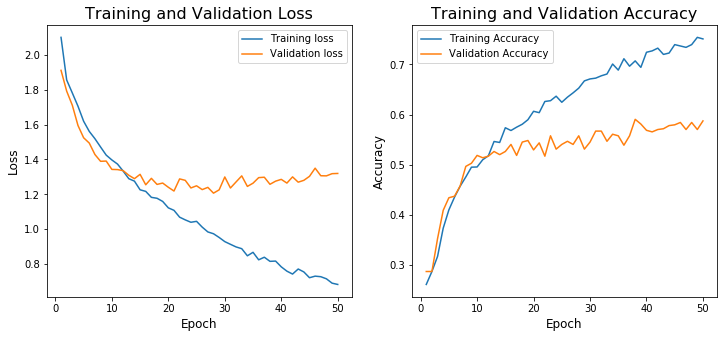

In [128]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_w2v_RNN1_epoch50_lr4_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN1_epoch50_lr4_gpu.csv'))
plot_loss_accuracy_curve(epoch_df)

<a id='Part3.10.4_link'></a>
### 3.10.4 Model evaluation

Here are some functions used in model evaluation.

In [81]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

In [42]:
def plot_acc_bar(cm,total_acc):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
    plt.yticks(fontsize=16)
    plt.xlabel('Category', fontsize=18)
    plt.ylabel('Accuracy%', fontsize=18)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
        ax.plot([-0.5, 8.5], [total_acc, total_acc], "k--", linewidth=2)
    ax.text(8.5, total_acc, 'Avg:\n'+str(total_acc)+'%', fontweight='bold', fontsize=18)

In [43]:
def plot_ROC_curve(pred_df):
    probas=np.array(pred_df.drop(['true_label','prediction','prob'],axis=1))

    fpr = dict()
    tpr = dict()
    auc_list = []
    label_to_class_dict = {i:l for i,l in enumerate(classes)}
    for i in np.arange(len(classes)):
        true_label_array = (pred_df.true_label.values == i).astype(np.uint8)
        probs = probas[:,i]
        fpr[i], tpr[i], _ = roc_curve(true_label_array, probs)
        auc_value = auc(fpr[i], tpr[i])
        auc_list.append(auc_value)

    palette=sns.color_palette('hls',len(classes))
    for i in np.arange(len(classes)):
        plt.plot(fpr[i], tpr[i], color = palette[i], label='{} (area = {:.2f})'.format(classes[i], auc_list[i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [44]:
def PM_RNN1_eval(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
  
    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    prob_array = np.array([])
    probs_array = np.arange(1,10).reshape(1,-1)
    
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        h = model.init_hidden(BATCH_SIZE)
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            h = tuple([each.data[:,:inputs.size(0),:] for each in h])
            output, h = model(inputs, h)
            loss = criterion(output, labels)
            test_loss += loss.item()*inputs.shape[0]
        
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(inputs)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))
      
            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))
            
      
    test_loss = test_loss/len(test_loader.sampler)
    test_acc = test_acc/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))
  
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = ['class_{}'.format(i) for i in range(1,10)])
    pred_df = pd.merge(pred_df, probs_df, left_index=True, right_index=True)
    return summary_df, pred_df

In [129]:
## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 256
n_layers = 2
model = PM_RNN1(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN1_epoch50_lr4_gpu.pth'), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models/Personalized_Medicine_w2v_RNN1_epoch50_lr4_gpu.pth'))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

In [130]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df, pred_df = PM_RNN1_eval(val_loader, model, criterion, device, classes)

Test Loss: 0.937197

Test Accuracy (Overall): 67.771%  (450.0/664.0)

Test Accuracy of Class_1: 75.221% (85.0/113.0)
Test Accuracy of Class_2: 46.154% (42.0/91.0)
Test Accuracy of Class_3: 5.556% (1.0/18.0)
Test Accuracy of Class_4: 71.533% (98.0/137.0)
Test Accuracy of Class_5: 27.083% (13.0/48.0)
Test Accuracy of Class_6: 70.909% (39.0/55.0)
Test Accuracy of Class_7: 89.529% (171.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 14.286% (1.0/7.0)


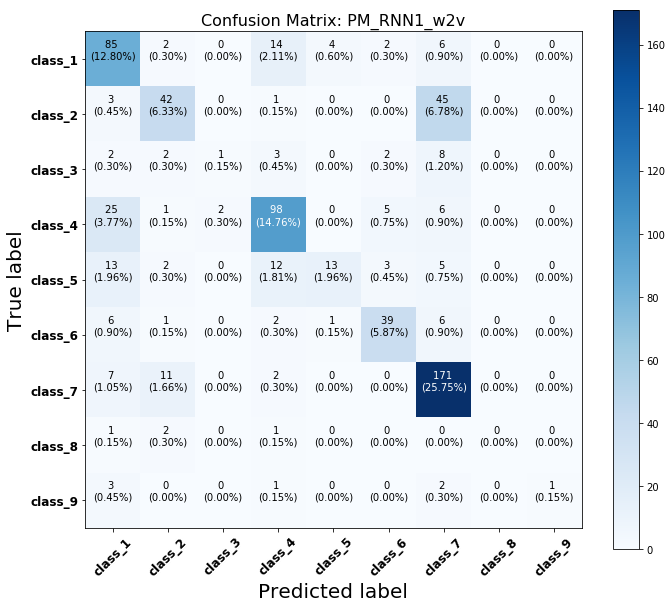

In [131]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: PM_RNN1_w2v', cmap=plt.cm.Blues)

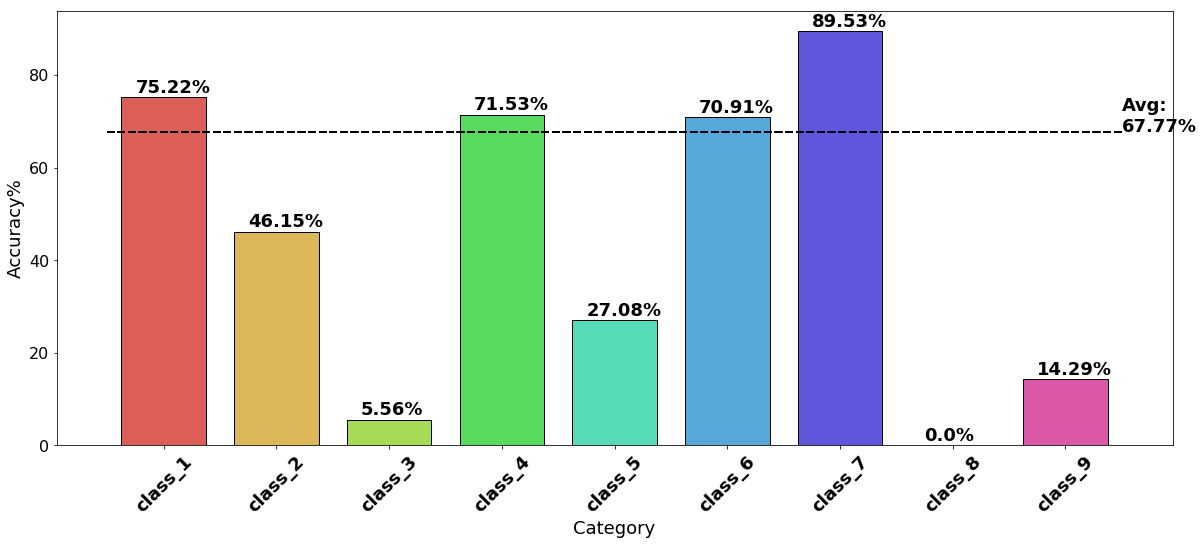

In [132]:
plot_acc_bar(cm,total_acc=67.77)

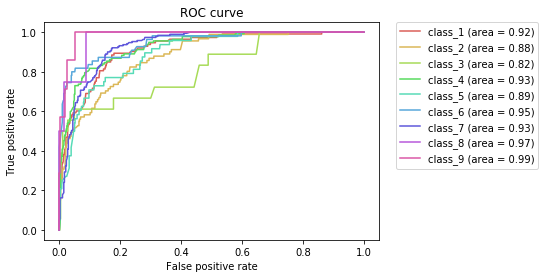

In [133]:
plot_ROC_curve(pred_df)

<a id='Part3.11_link'></a>
## 3.11 RNN model_2

<a id='Part3.11.1_link'></a>
### 3.11.1 Build PM_RNN2 model

In [58]:
class PM_RNN2(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(PM_RNN2, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        
        self.linear1 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        
        self.linear_out = nn.Linear(hidden_dim * 4, output_size)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([128, 2000])   torch.Size([BATCH_SIZE, MAX_LEN])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([128, 2000, 600])   torch.Size([BATCH_SIZE, MAX_LEN, embedding_dim])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        
        lstm1, _ = self.lstm1(embeds)   ## lstm1: torch.Size([128, 2000, 256])   torch.Size([BATCH_SIZE, MAX_LEN, hidden_dim*num_directions])
        # print("lstm1: {}".format(lstm1.shape))
        lstm2, _ = self.lstm2(lstm1)   ## lstm2: torch.Size([128, 2000, 256])   torch.Size([BATCH_SIZE, MAX_LEN, hidden_dim*num_directions])
        # print("lstm2: {}".format(lstm2.shape))
        
        # global average pooling
        avg_pool = torch.mean(lstm1, 1)   ## avg_pool: torch.Size([128, 256])   torch.Size([BATCH_SIZE, hidden_dim*num_directions])
        # print("avg_pool: {}".format(avg_pool.shape))
        # global max pooling
        max_pool, _ = torch.max(lstm2, 1)   ## max_pool: torch.Size([128, 256])   torch.Size([BATCH_SIZE, hidden_dim*num_directions])
        # print("max_pool: {}".format(max_pool.shape))
        
        h_conc = torch.cat((max_pool, avg_pool), 1)   ## h_conc: torch.Size([128, 512])   torch.Size([BATCH_SIZE, hidden_dim*4])
        # print("h_conc: {}".format(h_conc.shape))
        h_conc_linear1  = F.relu(self.linear1(h_conc))   ## h_conc_linear1: torch.Size([128, 512])   torch.Size([BATCH_SIZE, hidden_dim*4])
        # print("h_conc_linear1: {}".format(h_conc_linear1.shape))
        h_conc_linear2  = F.relu(self.linear2(h_conc))   ## h_conc_linear2: torch.Size([128, 512])   torch.Size([BATCH_SIZE, hidden_dim*4])
        # print("h_conc_linear2: {}".format(h_conc_linear2.shape))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2   ## hidden: torch.Size([128, 512])   torch.Size([BATCH_SIZE, hidden_dim*4])
        # print("hidden: {}".format(hidden.shape))
        result = self.linear_out(hidden)   ## result: torch.Size([128, 9])   torch.Size([BATCH_SIZE, output_size])
        # print("result: {}".format(result.shape))

        return result

In [59]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 128
n_layers = 1

model = PM_RNN2(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

print(model)

PM_RNN2(
  (embedding): Embedding(175039, 300)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (lstm1): LSTM(300, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear_out): Linear(in_features=512, out_features=9, bias=True)
)


<a id='Part3.11.2_link'></a>
### 3.11.2 Train PM_RNN2 model

In [60]:
def PM_RNN2_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path):
    '''
    Corresponding to SentimentRNN2, with nn.CrossEntropyLoss() as criterion
    '''
    epoch_dict={}
    valid_loss_min = np.Inf
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        epoch_dict[epoch] = {}
        # Training
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            #print('Step1')
            loss = criterion(output, labels)
            #print(loss)
            loss.backward()
            #print('Step2')
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            ## Update loss and acc values for the training process
            # print(loss)
            train_loss += loss.item()*inputs.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        else:
            # print("validation starts")
            with torch.no_grad():
                model.eval()
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    output = model(inputs)
                    loss = criterion(output, labels)
                    # print(loss)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*inputs.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)
                
                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)))
                
                ## save the model with the lowest val_loss and update valid_loss_min
                if val_loss <= valid_loss_min:
                    print('Validation loss decreased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_loss_min = val_loss
                
    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient = 'index')
    epoch_df['Epoch'] = np.arange(n_epochs)+1
    return model, epoch_df

In [63]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## define model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 256
n_layers = 2
model = PM_RNN2(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

## loss and optimization functions
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 20
clip=5

device: cpu


In [ ]:
save_path = os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN2_epoch50_lr4_gpu.pth')
model, epoch_df = PM_RNN2_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN2_epoch50_lr4_gpu.csv'))

<a id='Part3.11.3_link'></a>
### 3.11.3 Visualize training performance

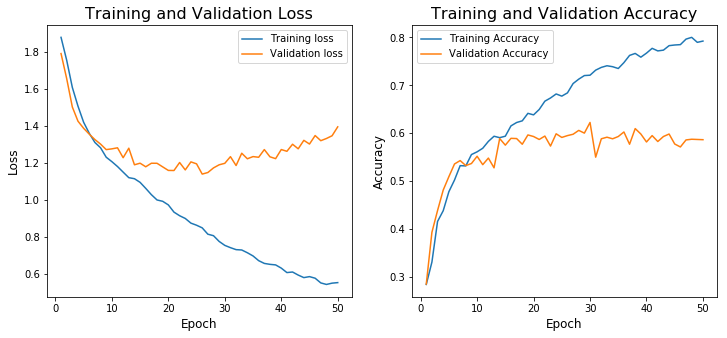

In [140]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_w2v_RNN2_epoch20_lr3_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN2_epoch50_lr4_gpu.csv'))
plot_loss_accuracy_curve(epoch_df)

<a id='Part3.11.4_link'></a>
### 3.11.4 Model evaluation

In [68]:
def PM_RNN2_eval(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
  
    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    prob_array = np.array([])
    probs_array = np.arange(1,10).reshape(1,-1)
    
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()*inputs.shape[0]
        
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(inputs)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))
      
            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))
            
      
    test_loss = test_loss/len(test_loader.sampler)
    test_acc = test_acc/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))
  
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = ['class_{}'.format(i) for i in range(1,10)])
    pred_df = pd.merge(pred_df, probs_df, left_index=True, right_index=True)
    return summary_df, pred_df

In [142]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 256
n_layers = 2
model = PM_RNN2(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN2_epoch50_lr4_gpu.pth'), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models/Personalized_Medicine_w2v_RNN2_epoch50_lr4_gpu.pth'))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [143]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df, pred_df = PM_RNN2_eval(val_loader, model, criterion, device, classes)

Test Loss: 1.138253

Test Accuracy (Overall): 60.090%  (399.0/664.0)

Test Accuracy of Class_1: 46.903% (53.0/113.0)
Test Accuracy of Class_2: 51.648% (47.0/91.0)
Test Accuracy of Class_3: 38.889% (7.0/18.0)
Test Accuracy of Class_4: 64.964% (89.0/137.0)
Test Accuracy of Class_5: 41.667% (20.0/48.0)
Test Accuracy of Class_6: 67.273% (37.0/55.0)
Test Accuracy of Class_7: 75.393% (144.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 28.571% (2.0/7.0)


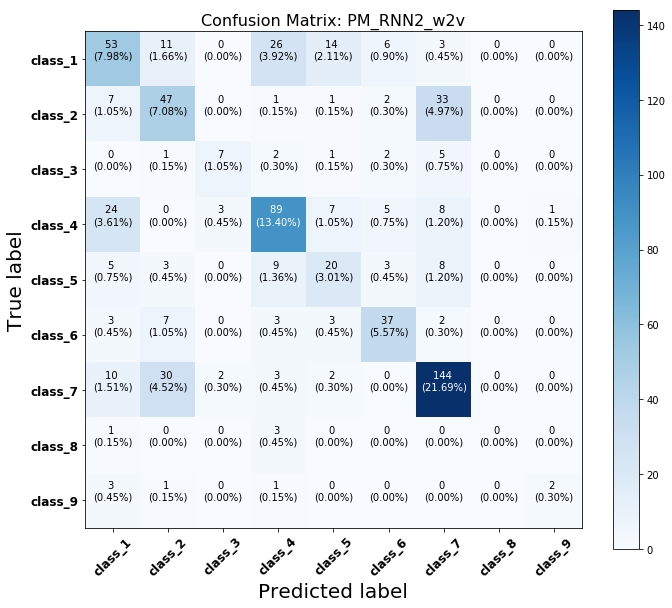

In [144]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: PM_RNN2_w2v', cmap=plt.cm.Blues)

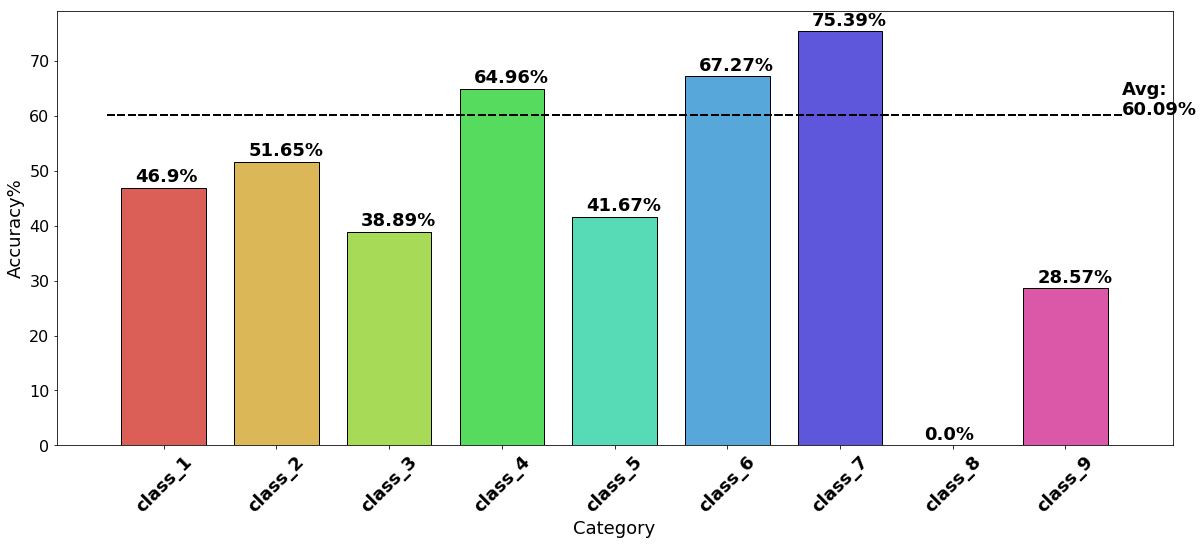

In [145]:
plot_acc_bar(cm,total_acc=60.09)

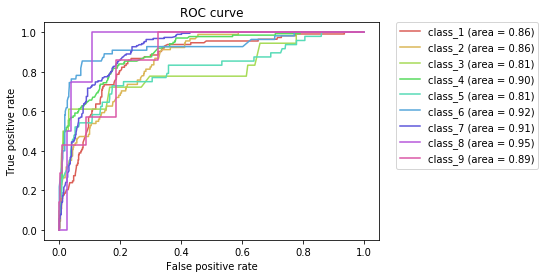

In [146]:
plot_ROC_curve(pred_df)

<a id='Part3.12_link'></a>
## 3.12 RNN model_3: BiLSTM + Conv1D

<a id='Part3.12.1_link'></a>
### 3.12.1 Build PM_RNN3 model

In [74]:
class PM_RNN3(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(PM_RNN3, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.pool = nn.MaxPool1d(2,2)
        
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        
        self.conv1_1 = nn.Conv1d(hidden_dim * 2,128,1,padding=0)
        self.conv1_2 = nn.Conv1d(128,256,3,padding=1)
        self.conv1_3 = nn.Conv1d(256,512,5,padding=2)
        
        self.linear1 = nn.Linear(1024, 1024)
        self.linear2 = nn.Linear(1024, 1024)
        
        self.dropout = nn.Dropout(0.2)
        
        self.linear_out = nn.Linear(1024, output_size)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([128, 2000])   torch.Size([BATCH_SIZE, MAX_LEN])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([128, 2000, 600])   torch.Size([BATCH_SIZE, MAX_LEN, embedding_dim])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        
        lstm1, _ = self.lstm1(embeds)   ## lstm1: torch.Size([128, 2000, 100])   torch.Size([BATCH_SIZE, MAX_LEN, hidden_dim*num_directions])
        # print("lstm1: {}".format(lstm1.shape))
        lstm2, _ = self.lstm2(lstm1)   ## lstm2: torch.Size([128, 2000, 100])   torch.Size([BATCH_SIZE, MAX_LEN, hidden_dim*num_directions])
        # print("lstm2: {}".format(lstm2.shape))
        
        ## Conv1d
        lstm1=lstm1.permute(0,2,1)   ## lstm1_pre_conv: torch.Size([128, 100, 2000])
        # print("lstm1_pre_conv: {}".format(lstm1.shape))
        lstm1 = F.relu(self.conv1_1(lstm1))   ## lstm1_conv1_1: torch.Size([128, 128, 2000])
        # print("lstm1_conv1_1: {}".format(lstm1.shape))
        lstm1 = F.relu(self.conv1_2(lstm1))   ## lstm1_conv1_2: torch.Size([128, 256, 2000])
        # print("lstm1_conv1_2: {}".format(lstm1.shape))
        lstm1 = F.relu(self.conv1_3(lstm1))   ## lstm1_conv1_3: torch.Size([128, 512, 2000])
        # print("lstm1_conv1_3: {}".format(lstm1.shape))
        lstm1 = self.pool(lstm1)
        lstm1 = self.dropout(lstm1)
        lstm1=lstm1.permute(0,2,1)   ## lstm1_post_conv: torch.Size([128, 1000, 512])
        # print("lstm1_post_conv: {}".format(lstm1.shape))
        
        lstm2=lstm2.permute(0,2,1)   ## lstm2_pre_conv: torch.Size([128, 100, 2000])
        # print("lstm2_pre_conv: {}".format(lstm2.shape))
        lstm2 = F.relu(self.conv1_1(lstm2))
        lstm2 = F.relu(self.conv1_2(lstm2))
        lstm2 = F.relu(self.conv1_3(lstm2))
        lstm2 = self.pool(lstm2)
        lstm2 = self.dropout(lstm2)
        lstm2=lstm2.permute(0,2,1)   ## lstm2_post_conv: torch.Size([128, 1000, 512])
        # print("lstm2_post_conv: {}".format(lstm2.shape))
        
        # global average pooling
        avg_pool = torch.mean(lstm1, 1)   ## avg_pool: torch.Size([128, 512])
        # print("avg_pool: {}".format(avg_pool.shape))
        # global max pooling
        max_pool, _ = torch.max(lstm2, 1)   ## max_pool: torch.Size([128, 512])
        # print("max_pool: {}".format(max_pool.shape))
        
        h_conc = torch.cat((max_pool, avg_pool), 1)   ## h_conc: torch.Size([128, 1024])
        # print("h_conc: {}".format(h_conc.shape))
        h_conc_linear1  = self.dropout(F.relu(self.linear1(h_conc)))   ## h_conc_linear1: torch.Size([128, 1024])
        # print("h_conc_linear1: {}".format(h_conc_linear1.shape))
        h_conc_linear2  = self.dropout(F.relu(self.linear2(h_conc)))   ## h_conc_linear2: torch.Size([128, 1024])
        # print("h_conc_linear2: {}".format(h_conc_linear2.shape))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2   ## hidden: torch.Size([128, 1024])
        # print("hidden: {}".format(hidden.shape))
        result = self.linear_out(hidden)   ## result: torch.Size([128, 9])   torch.Size([BATCH_SIZE, output_size])
        # print("result: {}".format(result.shape))

        return result

In [75]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 50
n_layers = 1
model = PM_RNN3(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)
print(model)

PM_RNN3(
  (embedding): Embedding(175039, 300)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(300, 50, batch_first=True, bidirectional=True)
  (lstm2): LSTM(100, 50, batch_first=True, bidirectional=True)
  (conv1_1): Conv1d(100, 128, kernel_size=(1,), stride=(1,))
  (conv1_2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_3): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (linear1): Linear(in_features=1024, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_out): Linear(in_features=1024, out_features=9, bias=True)
)


<a id='Part3.12.2_link'></a>
### 3.12.2 Train PM_RNN3 model

In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## define model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 50
n_layers = 1
model = PM_RNN3(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

## loss and optimization functions
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 20
clip=5

device: cpu


In [ ]:
save_path = os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN3_epoch50_lr4_gpu.pth')
model, epoch_df = PM_RNN2_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN3_epoch50_lr4_gpu.csv'))

<a id='Part3.12.3_link'></a>
### 3.12.3 Visualize training performance

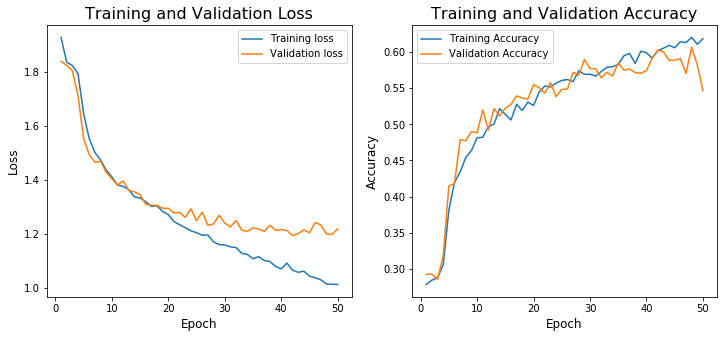

In [191]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_RNN3_epoch50_lr4_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN3_epoch50_lr4_gpu.csv'))
plot_loss_accuracy_curve(epoch_df)

<a id='Part3.12.4_link'></a>
### 3.12.4 Model evaluation

In [192]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 50
n_layers = 1
model = PM_RNN3(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN3_epoch50_lr4_gpu.pth'), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models/Personalized_Medicine_w2v_RNN3_epoch50_lr4_gpu.pth'))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [193]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df, pred_df = PM_RNN2_eval(val_loader, model, criterion, device, classes)

Test Loss: 1.193947

Test Accuracy (Overall): 59.639%  (396.0/664.0)

Test Accuracy of Class_1: 65.487% (74.0/113.0)
Test Accuracy of Class_2: 30.769% (28.0/91.0)
Test Accuracy of Class_3: 11.111% (2.0/18.0)
Test Accuracy of Class_4: 54.745% (75.0/137.0)
Test Accuracy of Class_5: 41.667% (20.0/48.0)
Test Accuracy of Class_6: 61.818% (34.0/55.0)
Test Accuracy of Class_7: 85.340% (163.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 0.000% (0.0/7.0)


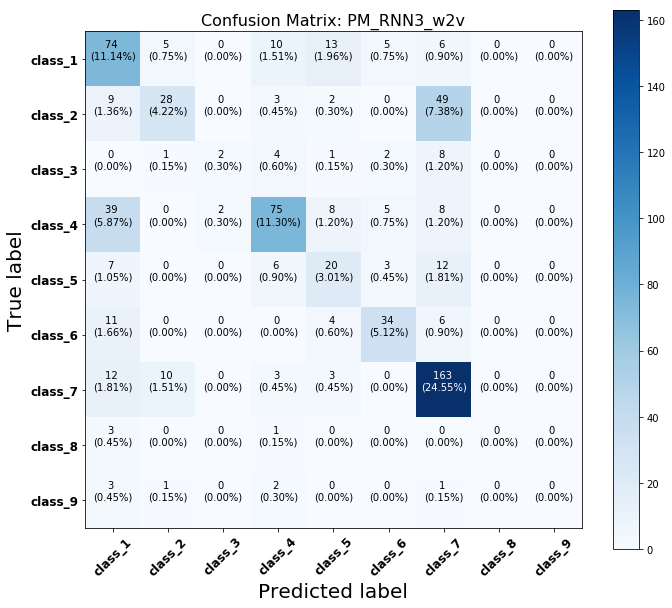

In [194]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: PM_RNN3_w2v', cmap=plt.cm.Blues)

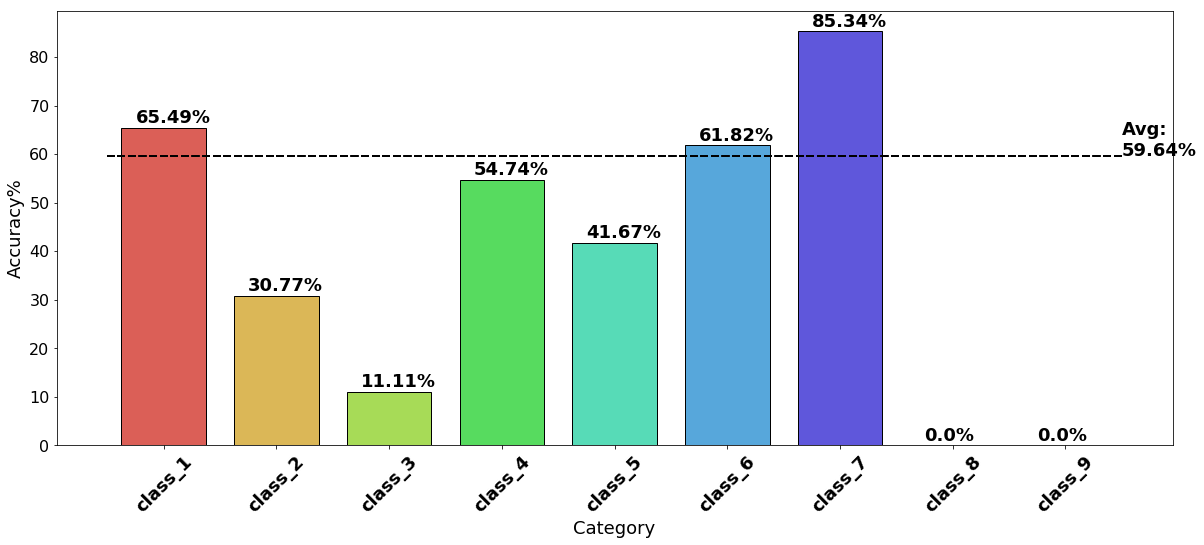

In [195]:
plot_acc_bar(cm,total_acc=59.64)

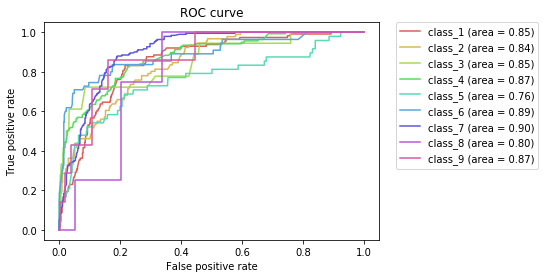

In [196]:
plot_ROC_curve(pred_df)

<a id='Part3.13_link'></a>
## 3.13 RNN model_4: Conv1D + BiLSTM

<a id='Part3.13.1_link'></a>
### 3.13.1 Build PM_RNN4 model 

In [101]:
class PM_RNN4(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(PM_RNN4, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.conv1_1 = nn.Conv1d(300,256,3,padding=1)
        self.conv1_2 = nn.Conv1d(256,128,1,padding=0)
        
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.lstm1 = nn.LSTM(128, hidden_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        
        self.pool = nn.MaxPool1d(2,2)
        
        self.linear1 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 4)
        
        self.dropout = nn.Dropout(0.2)
        
        self.linear_out = nn.Linear(hidden_dim * 4, output_size)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([64, 2000])   torch.Size([BATCH_SIZE, MAX_LEN])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([128, 2000, 600])   torch.Size([BATCH_SIZE, MAX_LEN, embedding_dim])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        
        ## Conv1d
        embeds=embeds.permute(0,2,1)   ## embeds_pre_conv: torch.Size([128, 600, 2000])   torch.Size([BATCH_SIZE, embedding_dim, MAX_LEN])
        # print("embeds_pre_conv: {}".format(embeds.shape))
        embeds = F.relu(self.conv1_1(embeds))   ## embeds_conv1_1: torch.Size([128, 256, 2000])
        # print("embeds_conv1_1: {}".format(embeds.shape))
        embeds = F.relu(self.conv1_2(embeds))   ## embeds_conv1_2: torch.Size([128, 128, 2000])
        # print("embeds_conv1_2: {}".format(embeds.shape))
        embeds = self.pool(embeds)   ## embeds_conv1_2_maxpool: torch.Size([128, 128, 1000])
        # print("embeds_conv1_2_maxpool: {}".format(embeds.shape))
        embeds = self.dropout(embeds)
        embeds=embeds.permute(0,2,1)   ## embeds_post_conv: torch.Size([128, 1000, 128])   torch.Size([BATCH_SIZE, MAX_LEN/2, *])
        # print("embeds_post_conv: {}".format(embeds.shape))
        
        lstm1, _ = self.lstm1(embeds)   ## lstm1: torch.Size([128, 1000, 256])   torch.Size([BATCH_SIZE, MAX_LEN/2, hidden_dim*n_layers])
        # print("lstm1: {}".format(lstm1.shape))
        lstm2, _ = self.lstm2(lstm1)   ## lstm2: torch.Size([128, 1000, 256])   torch.Size([BATCH_SIZE, MAX_LEN/2, hidden_dim*n_layers])
        # print("lstm2: {}".format(lstm2.shape))
        
        # global average pooling
        avg_pool = torch.mean(lstm1, 1)   ## avg_pool: torch.Size([128, 256])
        # print("avg_pool: {}".format(avg_pool.shape))
        # global max pooling
        max_pool, _ = torch.max(lstm2, 1)   ## max_pool: torch.Size([128, 256])
        # print("max_pool: {}".format(max_pool.shape))
        
        h_conc = torch.cat((max_pool, avg_pool), 1)   ## h_conc: torch.Size([128, 512])
        # print("h_conc: {}".format(h_conc.shape))
        h_conc_linear1  = self.dropout(F.relu(self.linear1(h_conc)))   ## h_conc_linear1: torch.Size([128, 512])
        # print("h_conc_linear1: {}".format(h_conc_linear1.shape))
        h_conc_linear2  = self.dropout(F.relu(self.linear2(h_conc)))   ## h_conc_linear2: torch.Size([128, 512])
        # print("h_conc_linear2: {}".format(h_conc_linear2.shape))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2   ## hidden: torch.Size([128, 512])
        # print("hidden: {}".format(hidden.shape))
        result = self.linear_out(hidden)   ## result: torch.Size([128, 9])   torch.Size([BATCH_SIZE, output_size])
        # print("result: {}".format(result.shape))

        return result

In [62]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 128
n_layers = 1
model = PM_RNN4(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)
print(model)

PM_RNN4(
  (embedding): Embedding(175039, 600)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (conv1_1): Conv1d(600, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_2): Conv1d(1024, 2048, kernel_size=(1,), stride=(1,))
  (lstm1): LSTM(2048, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_out): Linear(in_features=512, out_features=9, bias=True)
)


<a id='Part3.13.2_link'></a>
### 3.13.2 Train PM_RNN4 model

In [96]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## define model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 128
n_layers = 1
model = PM_RNN4(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

## loss and optimization functions
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 20
clip=5

device: cpu


In [ ]:
save_path = os.path.join(base_dir, 'models/Personalized_Medicine_RNN4_epoch20_lr3_gpu.pth')
model, epoch_df = PM_RNN2_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN4_epoch20_lr3_gpu.csv'))

<a id='Part3.13.3_link'></a>
### 3.13.3 Visualize training performance

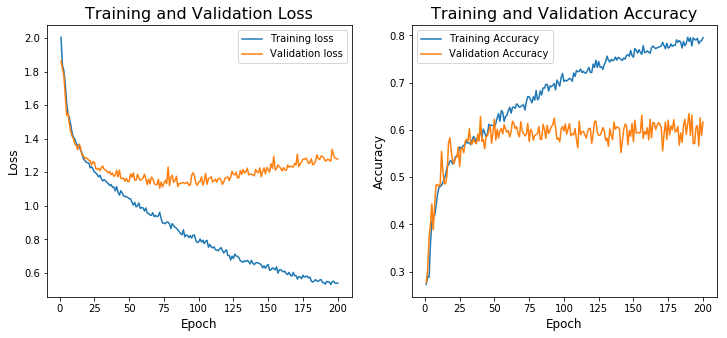

In [180]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_RNN4_epoch20_lr3_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN4_epoch200_lr4_gpu.csv'))
plot_loss_accuracy_curve(epoch_df)

<a id='Part3.13.4_link'></a>
### 3.13.4 Model evaluation

In [181]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 128
n_layers = 1
model = PM_RNN4(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN4_epoch200_lr4_gpu.pth'), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models/Personalized_Medicine_w2v_RNN4_epoch200_lr4_gpu.pth'))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [182]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df, pred_df = PM_RNN2_eval(val_loader, model, criterion, device, classes)

Test Loss: 1.105128

Test Accuracy (Overall): 60.090%  (399.0/664.0)

Test Accuracy of Class_1: 44.248% (50.0/113.0)
Test Accuracy of Class_2: 39.560% (36.0/91.0)
Test Accuracy of Class_3: 22.222% (4.0/18.0)
Test Accuracy of Class_4: 68.613% (94.0/137.0)
Test Accuracy of Class_5: 37.500% (18.0/48.0)
Test Accuracy of Class_6: 61.818% (34.0/55.0)
Test Accuracy of Class_7: 84.293% (161.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 28.571% (2.0/7.0)


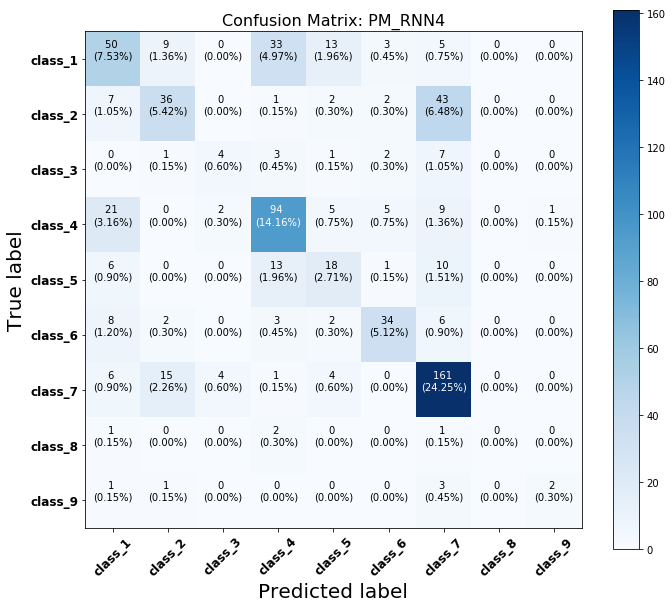

In [183]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: PM_RNN4', cmap=plt.cm.Blues)

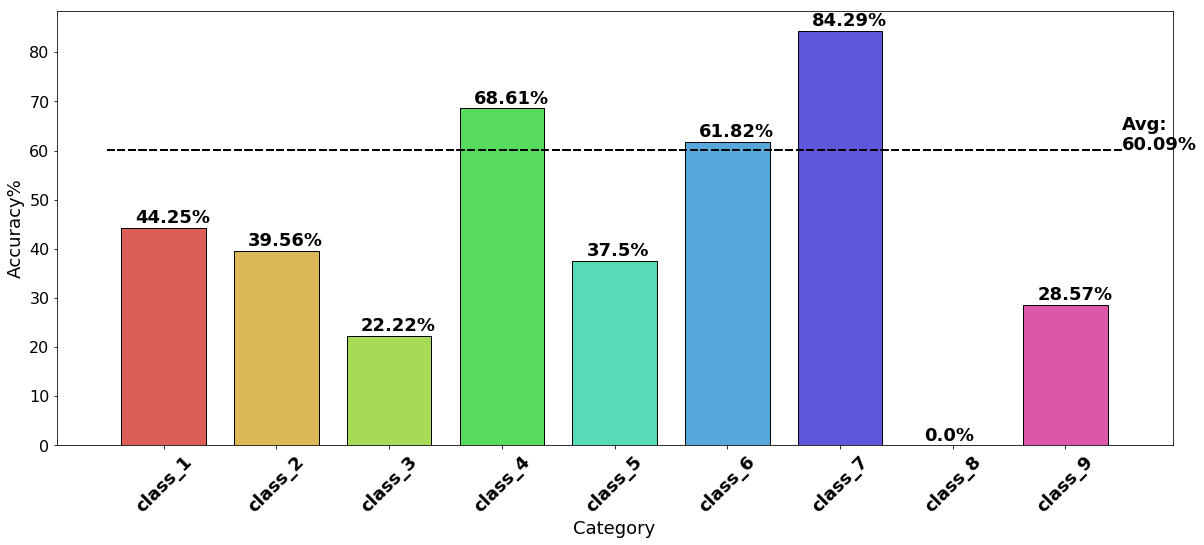

In [184]:
plot_acc_bar(cm,total_acc=60.09)

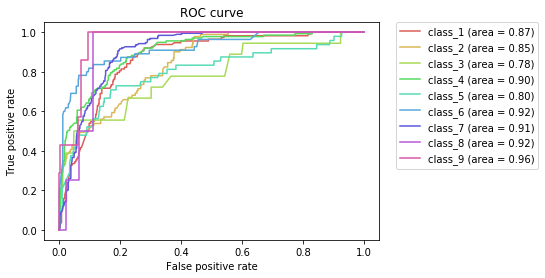

In [185]:
plot_ROC_curve(pred_df)

<a id='Part3.14_link'></a>
## 3.14 RNN model_5

<a id='Part3.14.1_link'></a>
### 3.14.1 Build PM_RNN5 model
<br>gru/lstm-->conv1_1/conv1_2-->avgpool/maxpool

In [110]:
class PM_RNN5(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    gru1/lstm1-->conv1_1/conv1_2(two different kernel sizes)-->avgpool/maxpool-->concatenate-->linear layers x3
    """

    def __init__(self, vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, conv_size, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(PM_RNN5, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        # self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.gru1 = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        #self.gru2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        #self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        
        self.conv1_1 = nn.Conv1d(hidden_dim * 2,conv_size,3,padding=1)
        self.conv1_2 = nn.Conv1d(hidden_dim * 2,conv_size,5,padding=2)
        
        self.linear1 = nn.Linear(512, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
        self.dropout = nn.Dropout(0.2)
        
        #self.linear_out = nn.Linear(1024, output_size)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)   ## x: torch.Size([64, 2000])   torch.Size([BATCH_SIZE, MAX_LEN])
        # print("x: {}".format(x.shape))
        x = x.long()
        embeds = self.embedding(x)   ## embeds: torch.Size([64, 2000, 600])   torch.Size([BATCH_SIZE, MAX_LEN, embedding_dim])
        # print("embeds: {}".format(embeds.shape))
        embeds = self.embedding_dropout(embeds)
        
        gru_1, _ = self.gru1(embeds)   ## gru_1: torch.Size([64, 2000, 128])
        # print("gru_1: {}".format(gru_1.shape))
        gru_1=gru_1.permute(0,2,1)   ## gru_1_pre_conv: torch.Size([64, 128, 2000])
        # print("gru_1_pre_conv: {}".format(gru_1.shape))
        
        gru_1c1 = F.relu(self.conv1_1(gru_1))   ## gru_1c1: torch.Size([64, 64, 2000])
        # print("gru_1c1: {}".format(gru_1c1.shape))
        gru_1c1=gru_1c1.permute(0,2,1)   ## gru_1c1_post_conv: torch.Size([64, 2000, 64])
        # print("gru_1c1_post_conv: {}".format(gru_1c1.shape))
        avg_pool_gru1c1 = torch.mean(gru_1c1, 1)   ## avg_pool_gru1c1: torch.Size([64, 64])
        # print("avg_pool_gru1c1: {}".format(avg_pool_gru1c1.shape))
        max_pool_gru1c1, _ = torch.max(gru_1c1, 1)   ## max_pool_gru1c1: torch.Size([64, 64])
        # print("max_pool_gru1c1: {}".format(max_pool_gru1c1.shape))
        
        gru_1c2 = F.relu(self.conv1_2(gru_1))   ## gru_1c2: torch.Size([64, 64, 2000])
        # print("gru_1c2: {}".format(gru_1c2.shape))
        gru_1c2=gru_1c2.permute(0,2,1)   ## gru_1c2_post_conv: torch.Size([64, 2000, 64])
        # print("gru_1c2_post_conv: {}".format(gru_1c2.shape))
        avg_pool_gru1c2 = torch.mean(gru_1c2, 1)   ## avg_pool_gru1c2: torch.Size([64, 64])
        # print("avg_pool_gru1c2: {}".format(avg_pool_gru1c2.shape))
        max_pool_gru1c2, _ = torch.max(gru_1c2, 1)   ## max_pool_gru1c2: torch.Size([64, 64])
        # print("max_pool_gru1c2: {}".format(max_pool_gru1c2.shape))
        
        
        lstm_1, _ = self.lstm1(embeds)   ## lstm_1: torch.Size([64, 2000, 128])
        # print("lstm_1: {}".format(lstm_1.shape))
        lstm_1=lstm_1.permute(0,2,1)   ## lstm_1_pre_conv: torch.Size([64, 128, 2000])
        # print("lstm_1_pre_conv: {}".format(lstm_1.shape))
        
        lstm_1c1 = F.relu(self.conv1_1(lstm_1))   ## lstm_1c1: torch.Size([64, 64, 2000])
        # print("lstm_1c1: {}".format(lstm_1c1.shape))
        lstm_1c1=lstm_1c1.permute(0,2,1)   ## lstm_1c1_post_conv: torch.Size([64, 2000, 64])
        # print("lstm_1c1_post_conv: {}".format(lstm_1c1.shape))
        avg_pool_lstm1c1 = torch.mean(lstm_1c1, 1)   ## avg_pool_lstm1c1: torch.Size([64, 64])
        # print("avg_pool_lstm1c1: {}".format(avg_pool_lstm1c1.shape))
        max_pool_lstm1c1, _ = torch.max(lstm_1c1, 1)   ## max_pool_lstm1c1: torch.Size([64, 64])
        # print("max_pool_lstm1c1: {}".format(max_pool_lstm1c1.shape))
        
        lstm_1c2 = F.relu(self.conv1_2(lstm_1))   ## lstm_1c2: torch.Size([64, 64, 2000])
        # print("lstm_1c2: {}".format(lstm_1c2.shape))
        lstm_1c2=lstm_1c2.permute(0,2,1)   ## lstm_1c2_post_conv: torch.Size([64, 2000, 64])
        # print("lstm_1c2_post_conv: {}".format(lstm_1c2.shape))
        avg_pool_lstm1c2 = torch.mean(lstm_1c2, 1)   ## avg_pool_lstm1c2: torch.Size([64, 64])
        # print("avg_pool_lstm1c2: {}".format(avg_pool_lstm1c2.shape))
        max_pool_lstm1c2, _ = torch.max(lstm_1c2, 1)   ## max_pool_lstm1c2: torch.Size([64, 64])
        # print("max_pool_lstm1c2: {}".format(max_pool_lstm1c2.shape))
        
        h_conc = torch.cat((avg_pool_gru1c1, max_pool_gru1c1, avg_pool_gru1c2, max_pool_gru1c2,
                            avg_pool_lstm1c1, max_pool_lstm1c1, avg_pool_lstm1c2, max_pool_lstm1c2), 1)   ## h_conc: torch.Size([64, 512])
        # print("h_conc: {}".format(h_conc.shape))
        h_conc_linear1  = self.dropout(F.relu(self.linear1(h_conc)))   ## h_conc_linear1: torch.Size([64, 256])
        # print("h_conc_linear1: {}".format(h_conc_linear1.shape))
        h_conc_linear2  = self.dropout(F.relu(self.linear2(h_conc_linear1)))   ## h_conc_linear2: torch.Size([64, 128])
        # print("h_conc_linear2: {}".format(h_conc_linear2.shape))
        
        result = self.linear3(h_conc_linear2)   ## result: torch.Size([64, 9])   torch.Size([BATCH_SIZE, output_size])
        # print("result: {}".format(result.shape))

        return result

In [64]:
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 64
n_layers = 1
conv_size=64
model = PM_RNN5(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, conv_size)
print(model)

PM_RNN5(
  (embedding): Embedding(175039, 600)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (gru1): GRU(600, 64, batch_first=True, bidirectional=True)
  (lstm1): LSTM(600, 64, batch_first=True, bidirectional=True)
  (conv1_1): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_2): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=9, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


<a id='Part3.14.2_link'></a>
### 3.14.2 Train PM_RNN5 model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## define model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 600
hidden_dim = 64
n_layers = 1
conv_size=64
model = PM_RNN5(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, conv_size)

## loss and optimization functions
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 20
clip=5

In [ ]:
save_path = os.path.join(base_dir, 'models/Personalized_Medicine_RNN5_epoch20_lr3_gpu.pth')
model, epoch_df = PM_RNN5_train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

In [ ]:
# epoch_df.to_csv(os.path.join(base_dir, 'models/Personalized_Medicine_RNN5_epoch20_lr3_gpu.csv'))

<a id='Part3.14.3_link'></a>
### 3.14.3 Visualize training performance

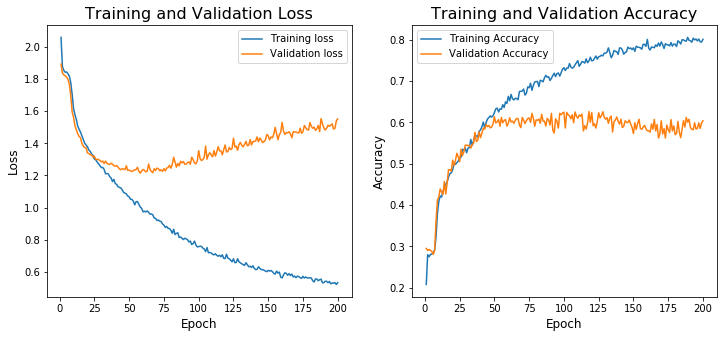

In [197]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_RNN5_epoch20_lr3_gpu.py
epoch_df=pd.read_csv(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN5_epoch200_lr4_gpu.csv'))
plot_loss_accuracy_curve(epoch_df)

<a id='Part3.14.4_link'></a>
### 3.14.4 Model evaluation

In [198]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

## Load trained model
vocab_size = len(tokenizer.word_index)+1
output_size = 9
embedding_dim = 300
hidden_dim = 64
n_layers = 1
conv_size=64
model = PM_RNN5(vocab_size, output_size, embedding_matrix, embedding_dim, hidden_dim, n_layers, conv_size)

if device.type == 'cpu':
    state_dict = torch.load(os.path.join(base_dir, 'models/Personalized_Medicine_w2v_RNN5_epoch200_lr4_gpu.pth'), map_location='cpu')
else:
    state_dict = torch.load(os.path.join(base_dir,'models/Personalized_Medicine_w2v_RNN5_epoch200_lr4_gpu.pth'))
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

device: cpu


In [199]:
criterion = nn.CrossEntropyLoss()
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df, pred_df = PM_RNN2_eval(val_loader, model, criterion, device, classes)

Test Loss: 1.214525

Test Accuracy (Overall): 60.542%  (402.0/664.0)

Test Accuracy of Class_1: 51.327% (58.0/113.0)
Test Accuracy of Class_2: 32.967% (30.0/91.0)
Test Accuracy of Class_3: 0.000% (0.0/18.0)
Test Accuracy of Class_4: 71.533% (98.0/137.0)
Test Accuracy of Class_5: 20.833% (10.0/48.0)
Test Accuracy of Class_6: 63.636% (35.0/55.0)
Test Accuracy of Class_7: 89.529% (171.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 0.000% (0.0/7.0)


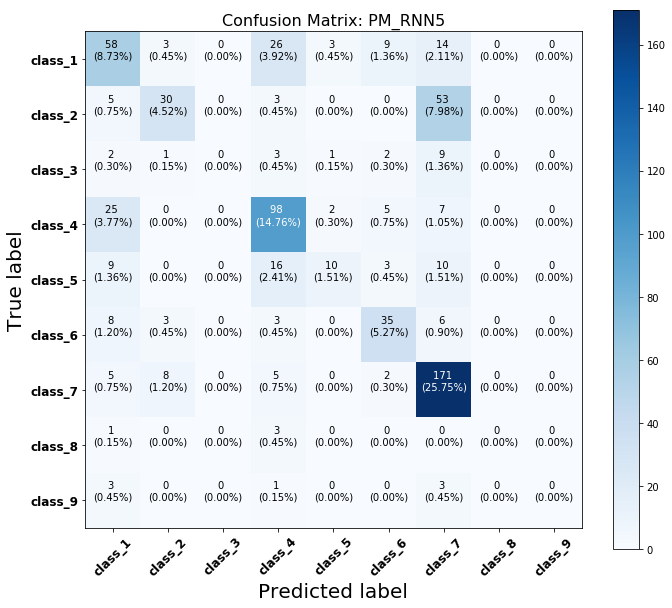

In [200]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: PM_RNN5', cmap=plt.cm.Blues)

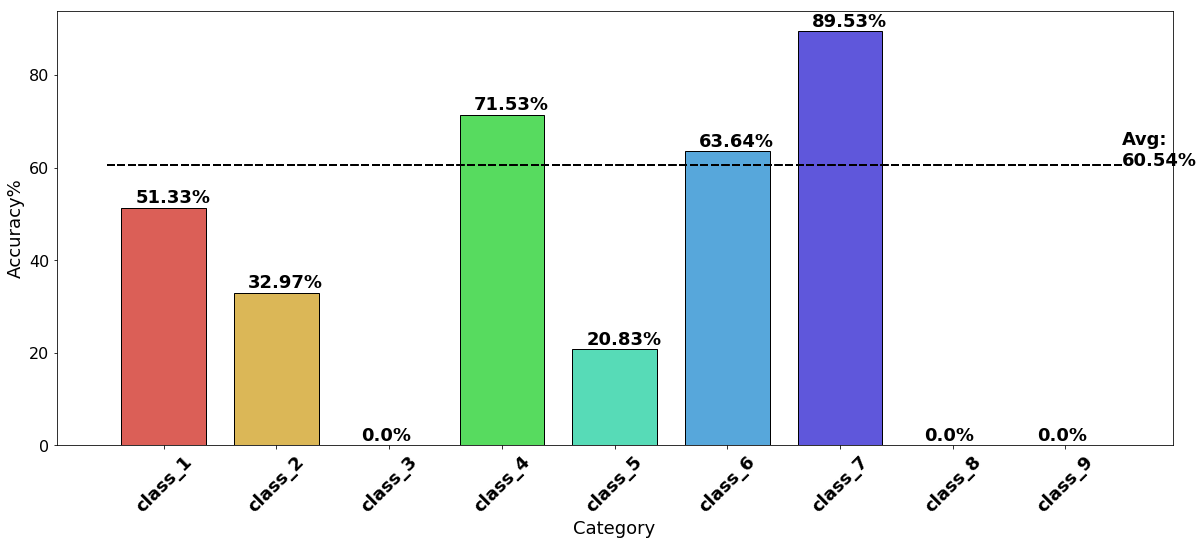

In [201]:
plot_acc_bar(cm,total_acc=60.54)

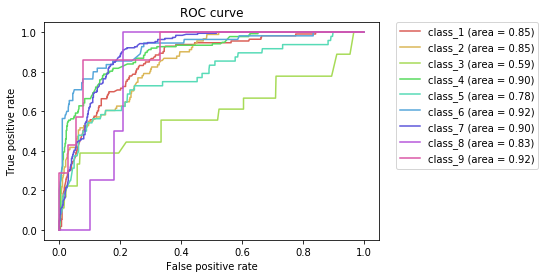

In [204]:
plot_ROC_curve(pred_df)

## Conclusion for RNN (self-trained Word2Vec)

<br>With self-trained Word2Vec as embedding matrix, 5 different RNN architectures have been tested for this project and the overall training performance is better than machine learning models, but not as good as using pre-trained Word2Vec. All the trained RNN models can achieve accuracy around 0.6 and the RNN1 model can achieve the highest accuracy score around 0.68.